<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/10_Nonlinear_intro/10_2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 10: Nonlinear Learning and Feature Engineering

# 10.2  Nonlinear Regression

In this Section we introduce the general framework of nonlinear regression via the engineering of nonlinear feature transformations, along with many examples ranging from toy datasets to classic examples from differential equations. While this sort of nonlinear feature engineering is only feasible with low dimensional datasets, by walking through these examples we flush out a number important concepts, coding principles, and jargon terms in a relatively simple environment that will be omnipresent in our discussion of nonlinear learning going forward.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone datasets
if not Path('chapter_10_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/10_Nonlinear_intro/chapter_10_datasets
else:
    print('chapter_10_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_10_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/10_Nonlinear_intro/chapter_10_library
else:
    print('chapter_10_library already cloned!')

# clone images
if not Path('chapter_10_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/10_Nonlinear_intro/chapter_10_images
else:
    print('chapter_10_images already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_10_library') 

# import section helper
import section_10_2_helpers

# dataset paths
data_path_1 = "chapter_10_datasets/unnorm_linregress_data.csv"
data_path_2 = "chapter_10_datasets/noisy_sin_subsample.csv"
data_path_3 = "chapter_10_datasets/galileo_ramp_data.csv"

# image paths
image_path_1 = "chapter_10_images/10_1.png"
image_path_2 = "chapter_10_images/Fig_1_12.png"

# standard imports
import matplotlib.pyplot as plt
import IPython, copy
from IPython.display import Image
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_10_datasets already cloned!
chapter_10_library already cloned!
chapter_10_images already cloned!


##  Modeling principles of linear regression

In Chapter 5 we detailed the basic linear model for regression as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + x_{1}w_1 + \cdots + x_{N}w_N
\end{equation}

or more compactly, denoting

\begin{equation}
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N}
\end{bmatrix}\,\,\,\,\,\,\,\,\text{and}
\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{x}}_{\,}=\begin{bmatrix}
1 \\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}
\end{equation}

as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} 
\end{equation}

Using a generic dataset of $P$ input-output pairs $\left\{\left(\mathbf{x}_p,y_p\right)\right\}_{p=1}^{P}$ we then minimized a proper regression cost function, e.g., the Least Squares (from [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html))

\begin{equation}
 g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P} \left(  \mathring{\mathbf{x}}_{p}^T \mathbf{w}   - \overset{\,}{{y}}_{p}^{\,} \right)^2
\end{equation}

in order to find optimal values for the parameters of our linear model (here, the vector $\mathbf{w}$).


##  Modeling principles of nonlinear regression

We can easily move from linear to general *nonlinear* regression, in both its principles and implementation, with few obstacles. We do this by swapping out the linear model used in Equation (1) with a nonlinear one, for instance a single nonlinear function $f$ that can be parameterized or unparameterized (e.g., tanh, a sine wave, etc.,). In the jargon of machine learning such a nonlinear function $f$ is often called a nonlinear *feature transformation*, since it transforms our original input features $\mathbf{x}$.  Our corresponding nonlinear model then takes the form

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right)  = 
w_0^{\,} + f\left(\mathbf{x}\right){w}_{1}^{\,}.
\end{equation}

Here we represent our set of parameters - both those potentially internal parameters of the function $f$ and those weights in the linear combination - via the set $\Theta$.  For example, in the case $f$ is trivially the identity $f\left(x\right) = x$ and our model is linear our parameter set $\Theta$ reduces to the weights of our linear combination.  As we did in the case of *linear regression*, here we could consider the ideal case - where we have knowledge of the best possible weights so that 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\Theta\right)   \approx y_p
\end{equation}

and to recover our ideal weights we would follow the same logic we used in deriving our cost functions for linear regression.  For example, we could minimize the Least Squares difference between both sides of the above and over all points.

Indeed in general we could create a nonlinear model that is the weighted sum of $B$ nonlinear functions of our input as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

where $f_1,\,f_2,\,...\,f_B$ are nonlinear parameterized or unparameterized functions - or *feature transformations* - and $w_0$ through $w_B$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\Theta$ and must be tuned properly.   Nonetheless the steps we take to formally employ such a model, its ideal weight values, the derivation of a Least Squares cost function, etc., are entirely similar to what we have now seen in the simpler instance of nonlinear regression (which itself does not differ from the steps taken in modeling the linear case).

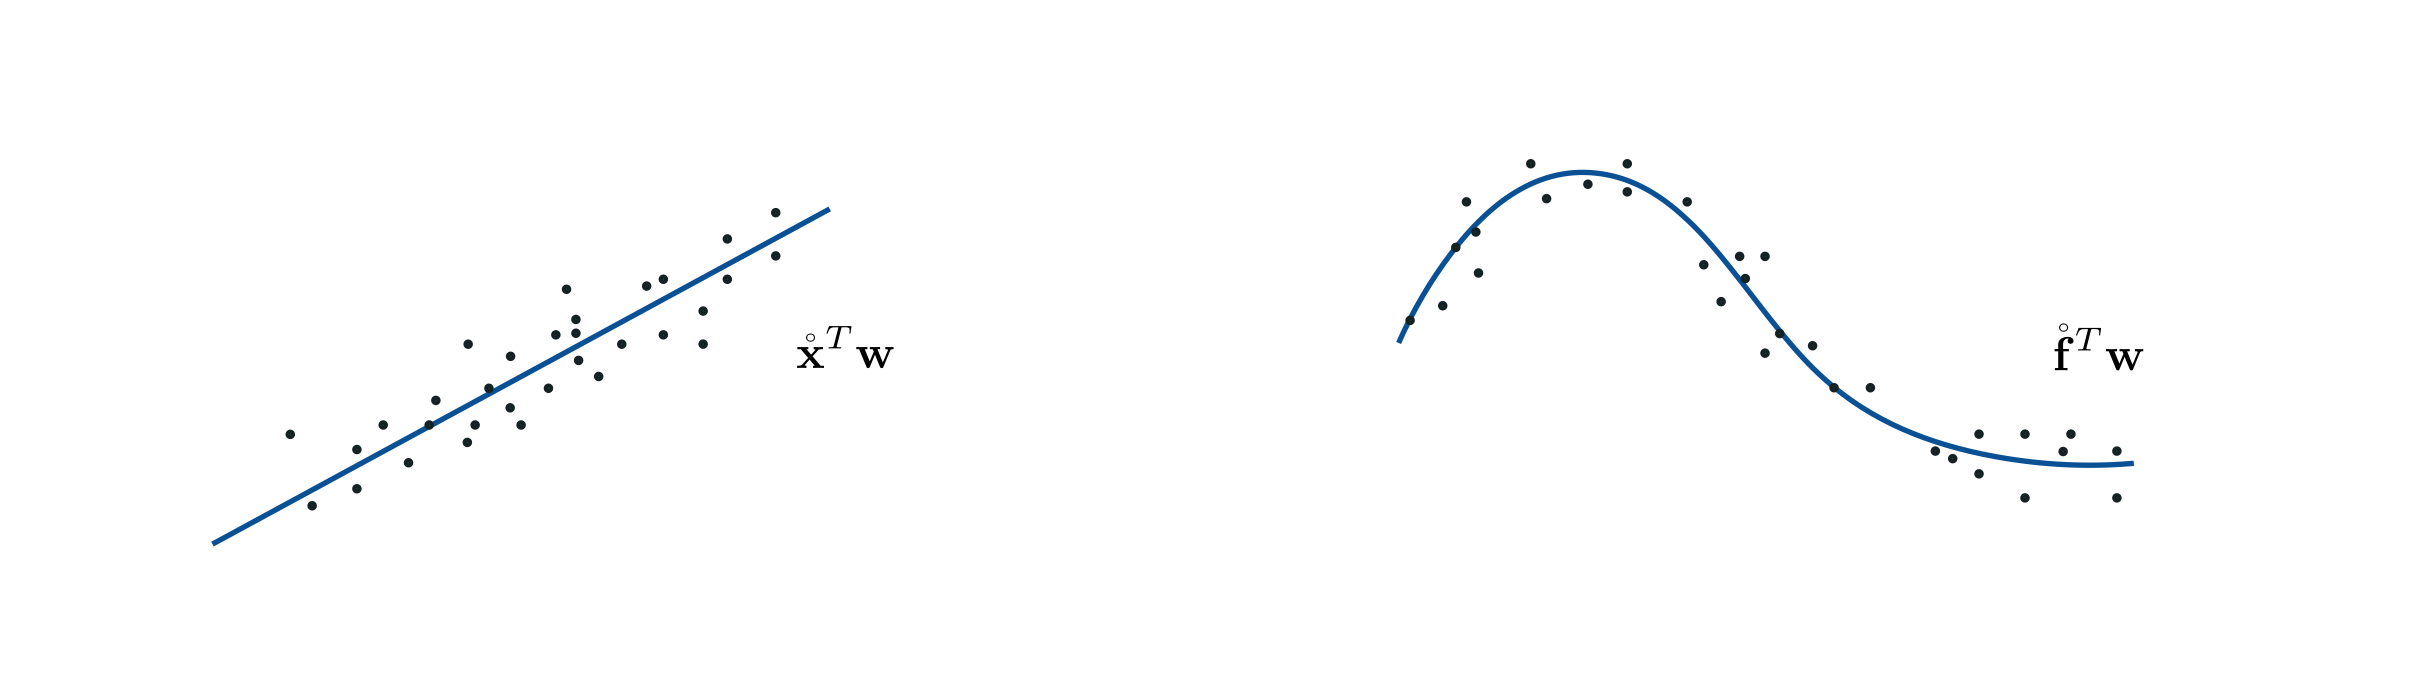

In [2]:
Image(image_path_1)

<figure>
<p>
</p>
<figcaption> <strong>Figure:</strong> <em> 
(left) Linear regression illustrated. Here the fit to the data is defined by the linear model $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}$. (right) Nonlinear regression is achieved by injecting nonlinear feature transformations into our model. Here the fit to the data is a nonlinear curve defined by $\mathring{\mathbf{f}}_{\,}^T\mathbf{w}^{\,}$.
</em>
</figcaption>
</figure>

In analogy to the linear case as shown in equation (3), here we too can compactly denote the generic nonlinear model in equation (6) by tacking a $1$ on top of the vector of nonlinear feature transformation as

\begin{equation}
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{B}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{f}}_{\,}=\begin{bmatrix}
1 \\
f_1\left(\mathbf{x}\right)\\
f_2\left(\mathbf{x}\right)\\
\vdots\\
f_B\left(\mathbf{x}\right)
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{f}}_{p}=\begin{bmatrix}
1 \\
f_1\left(\mathbf{x}_p\right)\\
f_2\left(\mathbf{x}_p\right)\\
\vdots\\
f_B\left(\mathbf{x}_p\right)
\end{bmatrix}
\end{equation}

and then writing our generic nonlinear model as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{w}.
\end{equation}

To tune the parameters of our general nonlinear model consisting of a linear combination of $B$ nonlinear feature transformations to a set of input / output pairs we also do precisely what we did in the linear case - we minimize a proper regression cost function over $\Theta$ like e.g., the Least Squares


\begin{equation}
 g\left(\Theta\right) = \frac{1}{P}\sum_{p=1}^{P} \left(  \mathring{\mathbf{f}}_{p}^T \mathbf{w}   - \overset{\,}{{y}}_{p}^{\,} \right)^2
\end{equation}

which is a direct generalization of equation (4).

##  Feature engineering examples

How do we determine the appropriate nonlinear feature transformations for our model, and their number $B$?  This is one of the most important challenges we face in machine learning, and is one which we will discuss extensively in the current Chapter as well as several of those to come.  Here we begin by discussing some simple instances when we can determine these items by *visualizing the data* and relying on our own pattern recognition abilities to determine the appropriate nonlinearities.  This kind of practice is referred to as nonlinear feature engineering.

#### <span style="color:#a50e3e;">Example 1. </span> The linear case

Let us first examine our original linear regression throug the lense of nonlinear feature engineering.   The figure below we shows a low dimensional regression dataset that looks is a clear candidate linear modeling.

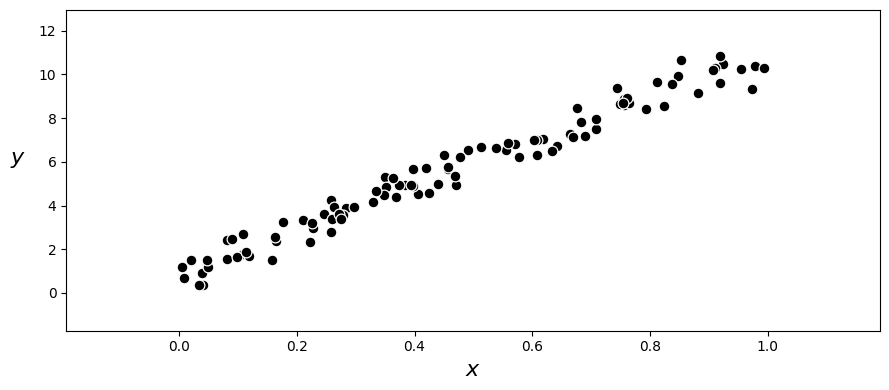

In [3]:
# load data
data = np.loadtxt(data_path_1,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = section_10_2_helpers.RegressionVisualizer(data)
demo.plot_data()

Since this data looks quite linear in nature, we would clearly employ a linear model.  In terms of feature engineering, here we employ the simple linear feature transformation

\begin{equation}
f\left(x\right) = x
\end{equation}

and in this notation our linear model is then

\begin{equation}
\text{model}\left(x,\Theta\right) = w_0 +f\left(x\right)w_{1\,}.
\end{equation}

Note how in performing standard normalization (subtracing the mean and dividing off the standard deviation of the input) we can actually think of the normalization as being a part of the feature transformation itself, and write it formally as

\begin{equation}
f\left(x \right) = \frac{x - \mu}{\sigma}
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset's input. 

Below we plot the fit provided by minimizing the Least Squares cost employing this feature transformation.

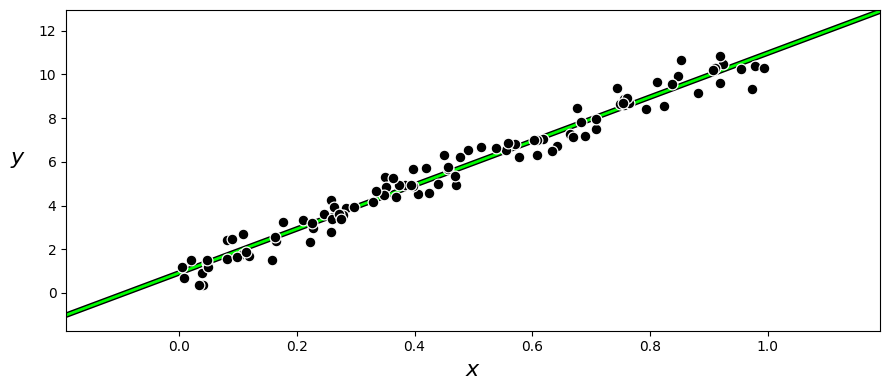

In [4]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(2,1); max_its = 500; alpha_choice = 10**(-1)

# the trivial linear feature transformation
def feature_transforms(x):
    return x

# run on normalized data
run = section_10_2_helpers.BaseSetup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

#### <span style="color:#a50e3e;">Example 2. </span> Modeling a familiar wave using a parameterized feature transformation

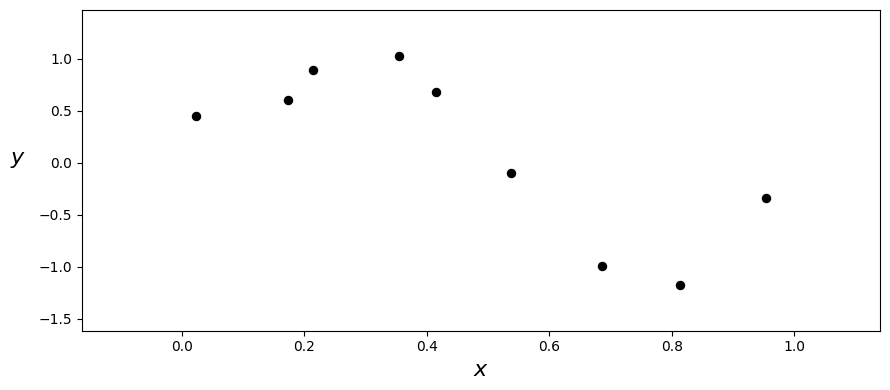

In [5]:
# load data
data = np.loadtxt(data_path_2,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = section_10_2_helpers.RegressionVisualizer(data)
demo.plot_data()

 This dataset looks sinusoidal, so we can defensibly propose a `model` consisting of completely *parameterized* sinusoidal function or *feature transformation* 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{sin}\left(w_0 + xw_1\right).
\end{equation}

We can then take as our model a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x,\Theta\right) = w_2 + f\left(x,\mathbf{w}\right)w_{3\,}.
\end{equation}

This seems like it could fit the data well if its parameters were all tuned properly via e.g., minimizing the associated Least Squares cost.  Tuning these parameters via gradient descent we can produce the following fit to our original data employing the nonlinear model above, which fits quite well.

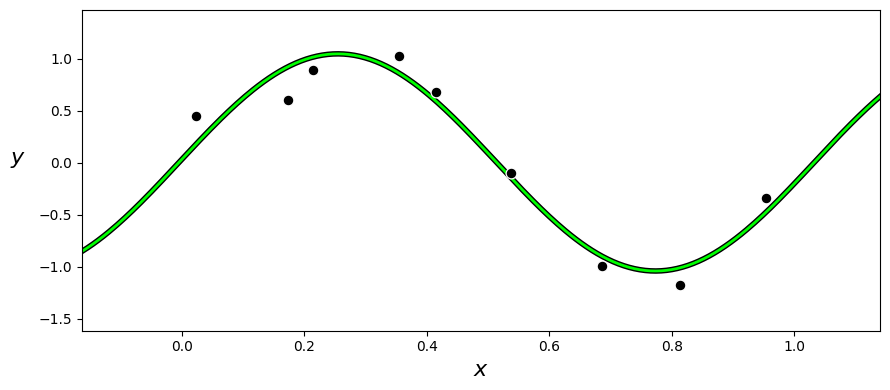

In [6]:
# the feature transformation from Example 2 
def feature_transforms(x,w):
    # calculate feature transform
    f = np.sin(w[0] + np.dot(x.T,w[1:])).T
    return f

# parameters for our two runs of gradient descent
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
max_its = 500; alpha_choice = 10**(-1)

# run on original data
run1 = section_10_2_helpers.BaseSetup(x,y,feature_transforms,'least_squares',normalize = 'None')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# run on normalized data
run2 = section_10_2_helpers.BaseSetup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run2.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run2.cost_history)
w_best = run2.weight_history[ind]
demo.plot_fit(w_best,run2.model,normalizer = run2.normalizer);

With our weights fully tuned notice that  since `model` is defined *linearly* in terms of its feature transformation we can represent our transformed input $x_p \longleftarrow f\left(x_p,\mathbf{w}^{\star}\right)$ and the correspnoding model fit $
\text{model}\left(x,\Theta^{\star}\right)$ in what is called the *transformed feature space*.  This is simply the space whose input is the feature transformed input $\,f\left(x_p,\mathbf{w}^{\star}\right)$ and whose output remains as $y$.  In this space our *nonlinear* fit is a *linear* one.  In other words, with our model completely tuned if plot the points $\left(f\left(x_1,\mathbf{w}^{\star}\right),y_1\right),\,\left(f\left(x_2,\mathbf{w}^{\star}\right),y_2\right)...,\left(f\left(x_P,\mathbf{w}^{\star}\right),y_P\right)$ - as we do below in the right panel - our model fits the transformed data *linearly*.

This finding is true in general with nonlinear regression problems.

> A properly designed feature (or set of features) provides a good nonlinear fit in the original feature space and, simultaneously, a good linear fit in the transformed feature space.

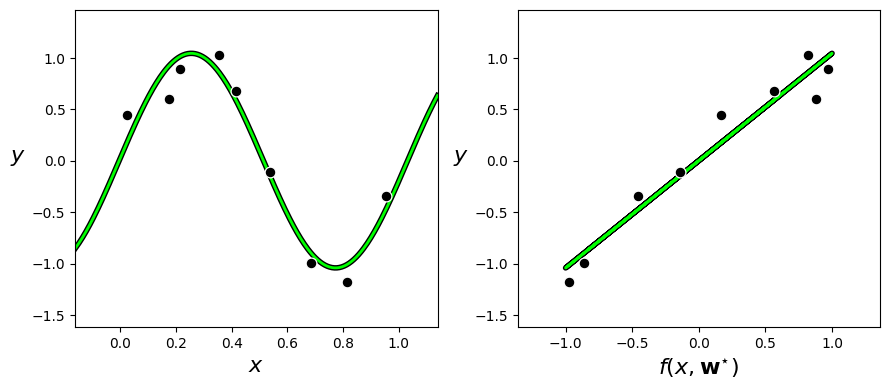

In [7]:
# plot data and fit in original and feature transformed space
demo.plot_fit_and_feature_space(w_best,run2.model,run2.feature_transforms,normalizer = run2.normalizer)

Finally note, as with the previous example that we can - and should - employ standard normalization to scale our input here when employing gradient descent to minimize the corresponding Least Squares cost.   *Feature scaling* is equally important in the context of nonlinear regression.  Here it also helps temper the contours of any regression cost function making it considerably easier for gradient descent to minimize.  Below we show the resulting cost function history resulting from a run of gradient descent employing the original and standard normalized versions of the input.  Comparing the two plots we can see that a significantly lower cost function value was found using the standard-normalized input.  Moreover, the convergence behavior displayed by the cost function plot on the original data is actually somewhat deceiving here - it appears to converge but not to a global minimum.

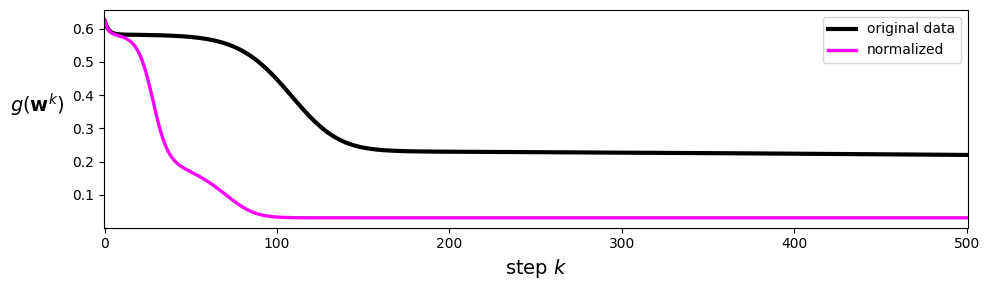

In [8]:
# plot the cost function history for a given run
static_plotter = section_10_2_helpers.StaticVisualizer()
static_plotter.plot_cost_histories([run1.cost_history,run2.cost_history],start = 0,points = False,labels = ['original data','normalized'])

#### <span style="color:#a50e3e;">Example 3. </span> Using an unparameterized feature transformation to model a classic physics dataset

In 1638 Galileo Galilei, infamous for his expulsion from the Catholic church for daring to claim that the earth orbited the sun and not the converse (as was the prevailing belief at the time) published his final book: [Discourses and Mathematical Demonstrations Relating to Two New Sciences](https://books.google.com/books?hl=en&lr=&id=8BhZAAAAYAAJ&oi=fnd&pg=PA11&ots=5pQfKe7Bby&sig=VVWwm0GtVvS9YnydNJXHU_UxBjA#v=onepage&q&f=false). In this book, written as a discourse among three men in the tradition of Aristotle, he described his experimental and philosophical evidence for the notion of uniformly accelerated physical motion. Specifically, Galileo (and others) had intuition that the acceleration of an object due to (the force we now know as) gravity is uniform in time, or in other words that the distance an object falls is directly proportional (i.e., linearly related) to the amount of time it has been traveling, squared. This relationship was empirically solidified using the following ingeniously simple experiment performed by Galileo.

Repeatedly rolling a metal ball down a grooved $\frac{1}{2}$ meter long piece of wood set at an incline as shown in the Figure below, Galileo timed how long the ball took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$, $\frac{3}{4}$, and all the way down the wood ramp. 

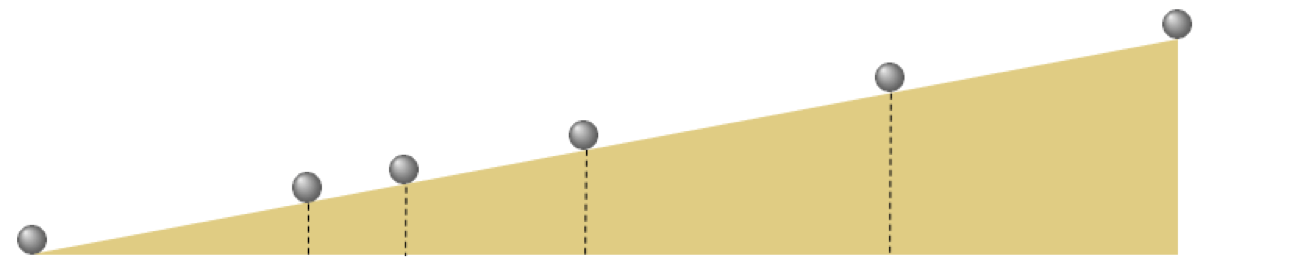

In [9]:
Image(image_path_2)

<p>
<figure>
  <figcaption>   
<strong>Figure 5:</strong> <em> Figurative illustration of
Galileo's ramp experiment setup used for exploring the relationship
between time and the distance an object falls due to gravity. To perform
this experiment he repeatedly rolled a ball down a ramp and timed
how long it took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$,
$\frac{3}{4}$, and all the way down the ramp.  </em>  </figcaption> 
</figure>
</p>

 Why didn't Galileo simply drop the ball from some height and time how long it took to reach certain distances to the ground?  Because no reliable way to measure time yet existed (he had to use a [water clock](https://en.wikipedia.org/wiki/Water_clock) for these experiments)!   Galileo was the one who set humanity on the route towards its first reliable time-piece in his studies of the [pendulum](http://galileo.rice.edu/sci/instruments/pendulum.html)
 
Data from a ([modern reenactment](Straulino, S, "Reconstruction of Galileo Galilei's experiment: the inclined plane", Physics Education 43, 3 2008, pp. 316.)) of these experiments (averaged over 30 trials), results in the 6 data points shown below.  Here the input axis is the number seconds while the output is the portion of the ramp traveled by the ball during the experiments.

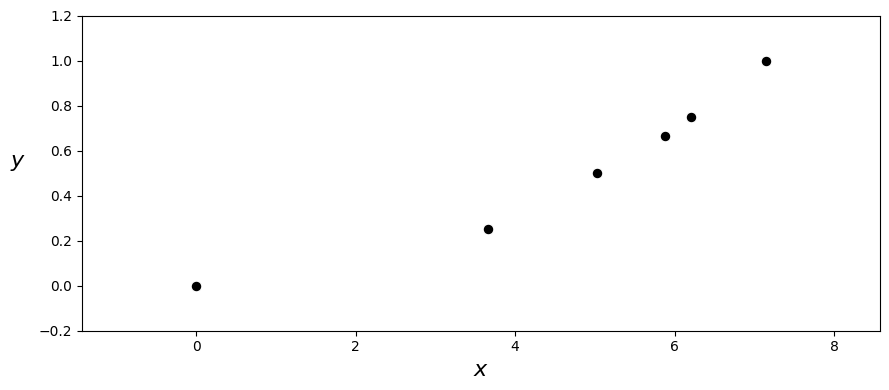

In [10]:
# load data
data = np.loadtxt(data_path_3,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = section_10_2_helpers.RegressionVisualizer(data)
demo.plot_data()

The data here certainly displays a nonlinear relationship and by viewing it - and using his physical intuition Galileo - intuited a *quadratic* relationship.  Or in our jargon that for some $w_0$, $w_1$, and $w_2$ the modeling function 

\begin{equation}
\text{model}(x,\Theta) = w_0 + xw_1 + x^2w_2
\end{equation}

provides the correct sort of nonlinearity to explain this data (albeit when the parameters are tuned correctly).  

Notice here how we have two *unparameterized* feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\Theta) = w_0 + f_1(x)\,w_1 + f_2(x)\,w_2
\end{equation}

which clearly shows how we are seeking out a proper linear relationship in the transformed feature space (which in this case is two-dimensional).  Note here - unlike the previous examples - neither of these feature transformations are *fixed* in that they take in no internal weights.

After standard-normalizing the input of this dataset we minimize the Least Squares cost via gradient descent, and plot the corresponding best nonlinear fit on the original data (left panel below) as well as corresponding linear fit on the feature transformed data (right panel below).  Notice that since we have two features in this instance our linear fit is in a space one dimension higher than the original input space defined by $x$.  In other words, the transformed feature space here has *two* inputs: one defined by each of the two features $f_1$ and $f_2$.

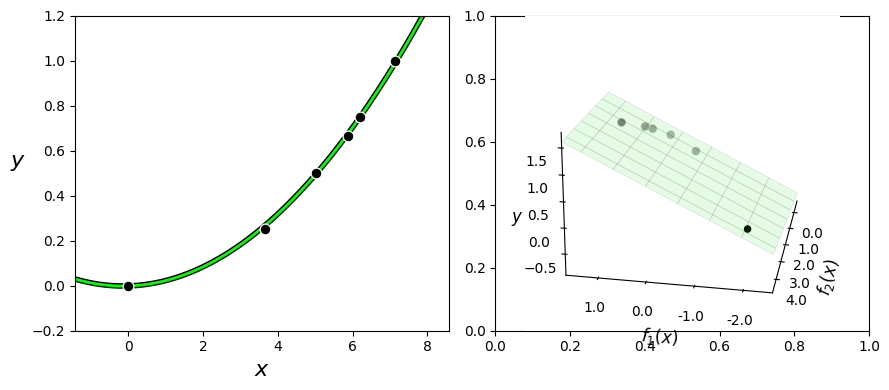

In [11]:
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(3,1);
max_its = 50; alpha_choice = 10**(-1);

# feature transform 
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

# run on original data
run1 = section_10_2_helpers.BaseSetup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# plot data and fit in original and feature transformed space
ind = np.argmin(run1.cost_history)
w_best = run1.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,run1.model,run1.feature_transforms,normalizer = run1.normalizer,view = [25,100])

Notice that trend is true more generally speaking: the more feature transforms we use the higher the up we go in terms of the dimensions of our transformed feature space / linear fit!  In general if our original input has dimension $N$ - and is written as $\mathbf{x}$ - and we use a `model` function that employs $B$ nonlinear feature transformations as

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

then our original space has $N$ dimensional input, while our transformed feature space is $B$ dimensional.  Note here that the set of all weights $\omega$ contains not only the weights $w_1,\,w_2,...,w_B$ from the linear combination, but also any features's internal parameters as well.

##  Implementing nonlinear regression in `Python`

Below we show a universal way to implement the generic nonlinear model shown in equation (6) above, generalizing our original linear implementation from [Section 5.1.3](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html).   In particular we implement the compact form given in equation (8).

In [12]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

Here our generic set of engineered feature transformations are implemented in the `Python` function `feature_transforms`.  Here we have implemented this function as generically as possible, to encompass the case where our desired feature transformations have internal parameters.  Here we package the model weights in the set $\Theta$ as `w`, which is a list containing the *internal weights* of  `feature_transforms` in its first entry `w[0]`, and the weights in the final linear combination of the model stored in second etnry `w[1]`).

e.g., the `feature_transforms` function employed in Example 2 above can be implemented as follows

In [13]:
# the feature transformation from Example 2 
def feature_transforms(x,w):
    # calculate feature transform
    f = np.sin(w[0] + np.dot(x.T,w[1:])).T
    return f


If our desired feature transformations do not have internal parameters we can either leave the parameter input to this function empty, or implement the model above slightly differently by computing our set of feature transformations as


                                f = feature_transforms(x)
                        
                        
and computing the linear combination of these transformed features in line 7 as


                                a = w[0] + np.dot(f.T,w[1:])

In either case, in order to successfully perform nonlinear regression we can focus our attention solely on implementing the function `feature_transforms` - employing the `autograd`'-wrapped `numpy` library if we wish to employ automatic differentiation (see [Section 3.5](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_5_Automatic.html)).  Since only our implemented `model` needs adjusting, nothing about how we implement our *regression cost functions* changes from the originnal context of linear regression detailed in Chapter 5.  In other words, once we have implemented a given set of feature transformations correctly, employing the `model` above we can then tune the parameters of our nonlinear regression precisely as we have done in Chapter 5 employing any regression cost function and local optimization scheme.